In [19]:
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.models import iTransformer
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic
from neuralforecast.losses.pytorch import MSE, MAE

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Read the CSV file
df = pd.read_csv('model_data.csv')



In [ ]:
df

In [27]:
# Drop the timestamp column as it's not needed for modeling
df = df.drop('ts_event', axis=1)

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [28]:

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [35]:
# Initialize and train XGBoost model for regression
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    learning_rate=0.000001,
    max_depth=12,
    n_estimators=100
)

# Train the model
xgb_model.fit(
    X_train_scaled, 
    y_train,
    eval_set=[(X_train_scaled, y_train), (X_test_scaled, y_test)],
    eval_metric='rmse',
    early_stopping_rounds=1000,
    verbose=False
)

# Make predictions
y_pred = xgb_model.predict(X_test_scaled)


/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [37]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Root Mean Squared Error: {rmse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"R-squared Score: {r2:.6f}")


Model Performance Metrics:
Root Mean Squared Error: 0.247863
Mean Absolute Error: 0.208267
R-squared Score: -0.148510


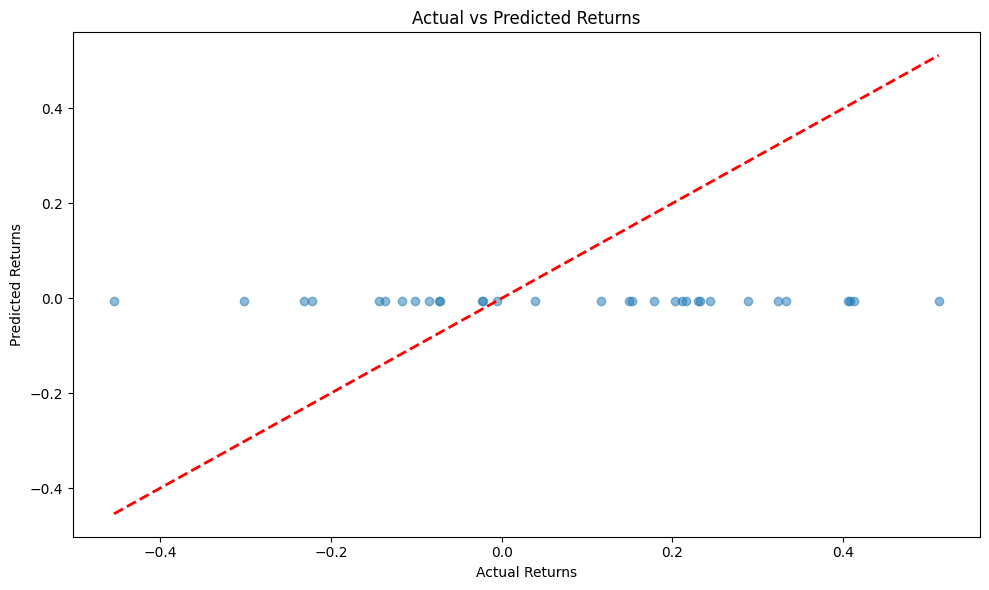

In [38]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title('Actual vs Predicted Returns')
plt.tight_layout()
plt.show()



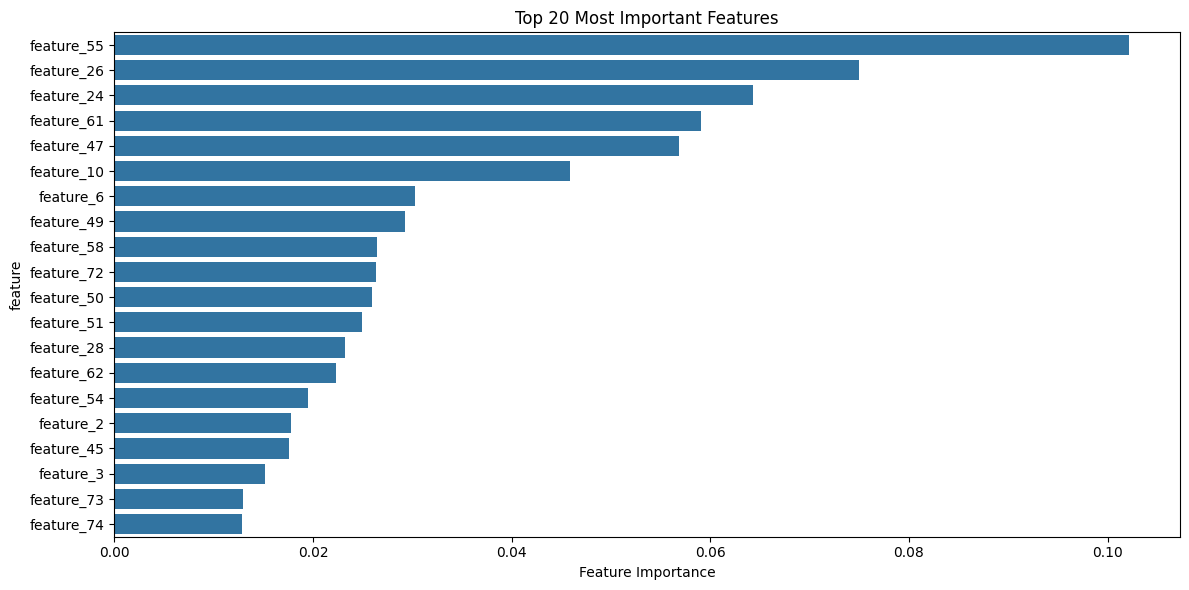

In [18]:
# Plot feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
})
feature_importance = feature_importance.sort_values('importance', ascending=False).head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Top 20 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()



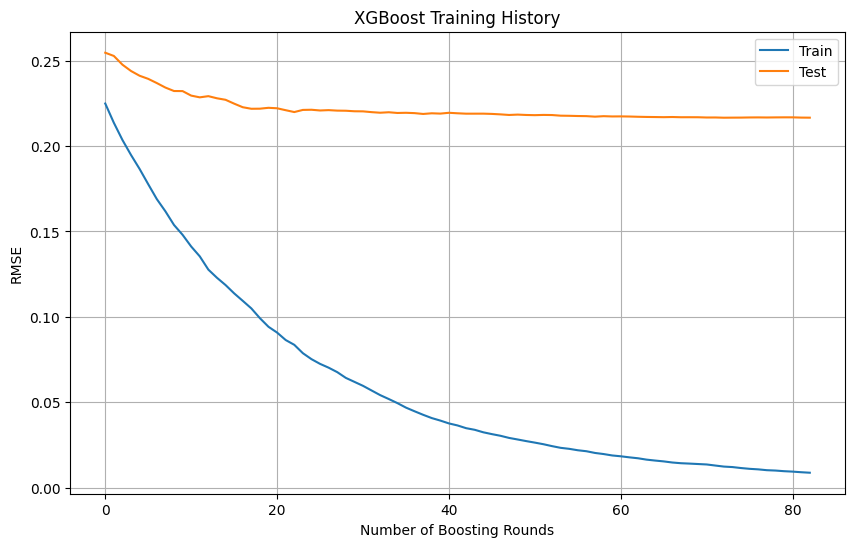

In [19]:
# Plot training history
results = xgb_model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['rmse'], label='Train')
plt.plot(x_axis, results['validation_1']['rmse'], label='Test')
plt.legend()
plt.ylabel('RMSE')
plt.xlabel('Number of Boosting Rounds')
plt.title('XGBoost Training History')
plt.grid()
plt.show()



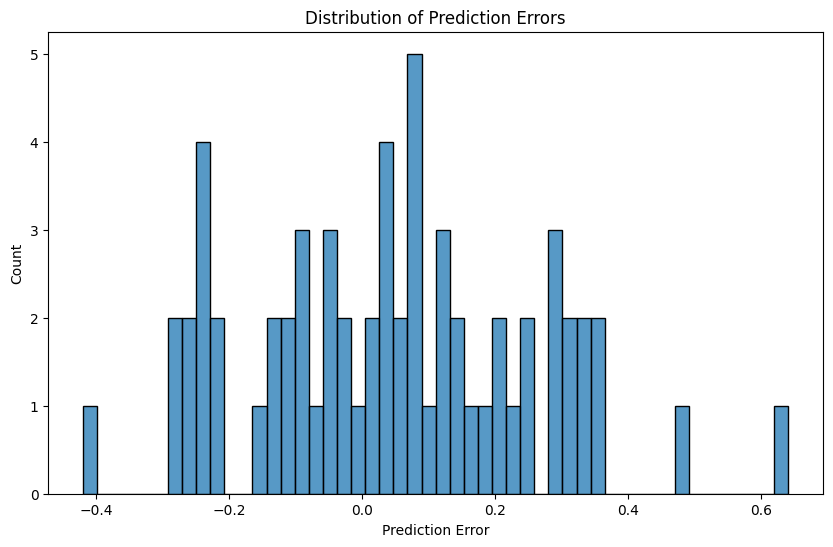

In [20]:
# Plot distribution of prediction errors
errors = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.histplot(errors, bins=50)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')
plt.ylabel('Count')
plt.show()

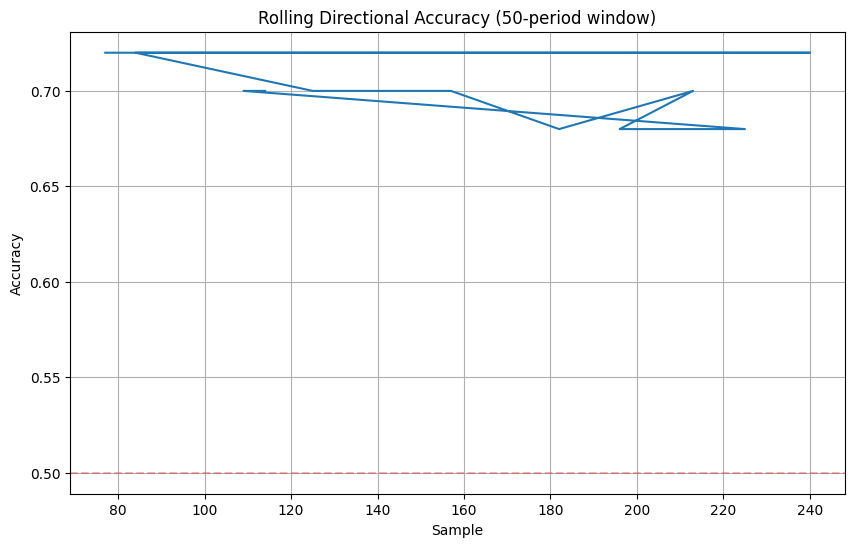


Overall Directional Accuracy: 0.7302


In [21]:
# Calculate and plot rolling prediction accuracy
results_df = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
})

# Calculate the directional accuracy (sign agreement between actual and predicted)
results_df['correct_direction'] = np.sign(results_df['actual']) == np.sign(results_df['predicted'])
rolling_accuracy = results_df['correct_direction'].rolling(window=50).mean()

plt.figure(figsize=(10, 6))
plt.plot(rolling_accuracy)
plt.title('Rolling Directional Accuracy (50-period window)')
plt.ylabel('Accuracy')
plt.xlabel('Sample')
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
plt.grid(True)
plt.show()

# Print directional accuracy
directional_accuracy = (np.sign(y_pred) == np.sign(y_test)).mean()
print(f"\nOverall Directional Accuracy: {directional_accuracy:.4f}")

Fitting 5 folds for each of 50 candidates, totalling 250 fits


/var/folders/8p/dwqnp65s0s77jdbm4_6z4vp80000gn/T/ipykernel_25522/3984511586.py:21: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill')



Best parameters found:
{'colsample_bytree': 0.6780971951192178, 'gamma': 0.36122605763075266, 'learning_rate': 0.09423170873225672, 'max_depth': 5, 'min_child_weight': 1, 'n_estimators': 116, 'reg_alpha': 0.994550510797341, 'reg_lambda': 0.46994451399094295, 'subsample': 0.7118241367187035}

Best RMSE: 0.2826208643996225

Final Model Performance Metrics:
Root Mean Squared Error: 0.175920
Mean Absolute Error: 0.136832
R-squared Score: -0.232439
Directional Accuracy: 0.4808


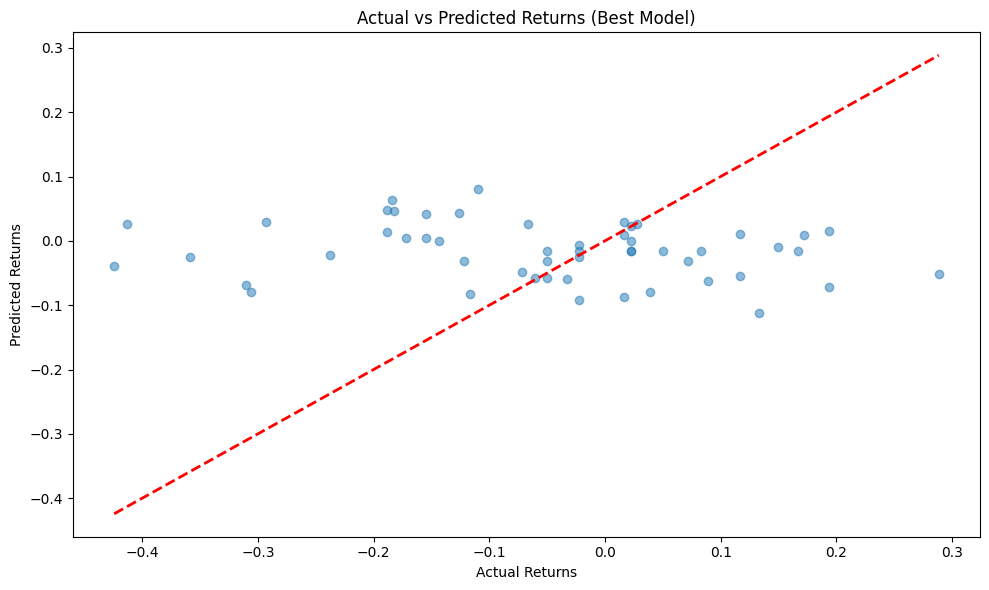

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint

# Add some feature engineering
def add_engineered_features(df):
    # Rolling means of some features
    for col in ['feature_0', 'feature_1', 'feature_2']:
        if col in df.columns:
            df[f'{col}_rolling_mean_5'] = df[col].rolling(5).mean()
            df[f'{col}_rolling_std_5'] = df[col].rolling(5).std()
    
    # Fill NaN values created by rolling windows
    df = df.fillna(method='bfill')
    return df

df = add_engineered_features(df)

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Use TimeSeriesSplit instead of random split
tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Use RobustScaler instead of StandardScaler to handle outliers better
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define hyperparameter search space
param_distributions = {
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'n_estimators': randint(100, 300),
    'min_child_weight': randint(1, 7),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1)
}

# Initialize base model for hyperparameter tuning
base_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    tree_method='hist'  # Faster training
)

# Perform randomized search with time series cross-validation
random_search = RandomizedSearchCV(
    estimator=base_model,
    param_distributions=param_distributions,
    n_iter=50,  # Number of parameter settings sampled
    cv=tscv,
    scoring='neg_mean_squared_error',
    random_state=42,
    n_jobs=-1,
    verbose=1
)

# Fit random search
random_search.fit(X_train_scaled, y_train)

# Print best parameters and score
print("\nBest parameters found:")
print(random_search.best_params_)
print(f"\nBest RMSE: {(-random_search.best_score_)**0.5}")

# Train final model with best parameters
best_model = random_search.best_estimator_

# Predict on test set
y_pred = best_model.predict(X_test_scaled)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nFinal Model Performance Metrics:")
print(f"Root Mean Squared Error: {rmse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"R-squared Score: {r2:.6f}")

# Calculate directional accuracy
directional_accuracy = (np.sign(y_pred) == np.sign(y_test)).mean()
print(f"Directional Accuracy: {directional_accuracy:.4f}")

# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title('Actual vs Predicted Returns (Best Model)')
plt.tight_layout()
plt.show()

In [41]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
import optuna

# Read and prepare the data
df = pd.read_csv('model_data.csv')
df = df.drop('ts_event', axis=1)

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the data into train and test sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use RobustScaler instead of StandardScaler to handle outliers better
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection using XGBoost's built-in importance
def select_features(X_train_scaled, X_test_scaled, X, threshold=0.01):
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42
    )
    model.fit(X_train_scaled, y_train)
    
    selector = SelectFromModel(model, prefit=True, threshold=threshold)
    X_train_selected = selector.transform(X_train_scaled)
    X_test_selected = selector.transform(X_test_scaled)
    
    selected_features = X.columns[selector.get_support()].tolist()
    print(f"Selected {len(selected_features)} features")
    
    return X_train_selected, X_test_selected, selected_features

# Optuna objective function for hyperparameter optimization
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
    }
    
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        random_state=42,
        **params
    )
    
    # Use TimeSeriesSplit for validation
    tscv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(model, X_train_selected, y_train, cv=tscv, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    
    return rmse

# Perform feature selection
X_train_selected, X_test_selected, selected_features = select_features(X_train_scaled, X_test_scaled, X)

# Optimize hyperparameters using Optuna
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("\nBest hyperparameters:", best_params)

# Train final model with best parameters
final_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    random_state=42,
    **best_params
)

# Train with early stopping
final_model.fit(
    X_train_selected, 
    y_train,
    eval_set=[(X_train_selected, y_train), (X_test_selected, y_test)],
    eval_metric='rmse',
    early_stopping_rounds=20,
    verbose=False
)

# Make predictions
y_pred = pd.Series(final_model.predict(X_test_selected), index=y_test.index)

# Calculate performance metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
directional_accuracy = (np.sign(y_pred) == np.sign(y_test)).mean()

print("\nModel Performance Metrics:")
print(f"Root Mean Squared Error: {rmse:.6f}")
print(f"Mean Absolute Error: {mae:.6f}")
print(f"R-squared Score: {r2:.6f}")
print(f"Directional Accuracy: {directional_accuracy:.4f}")

# Calculate returns based on predictions
def calculate_returns(predictions, actual, threshold=0.0):
    # Ensure predictions and actual are Series with the same index
    predictions = pd.Series(predictions, index=actual.index)
    positions = pd.Series(0, index=actual.index)
    positions[abs(predictions) > threshold] = np.sign(predictions[abs(predictions) > threshold])
    returns = positions * actual
    return returns

# Calculate returns for different prediction thresholds
thresholds = [0.0, 0.001, 0.002, 0.003, 0.004, 0.005]
threshold_results = []

for threshold in thresholds:
    returns = calculate_returns(y_pred, y_test, threshold)
    sharpe = np.sqrt(252) * returns.mean() / returns.std()  # Annualized Sharpe Ratio
    filtered_actual = y_test[returns != 0]
    filtered_returns = returns[returns != 0]
    accuracy = (np.sign(filtered_returns) == np.sign(filtered_actual)).mean()
    coverage = (abs(y_pred) > threshold).mean()
    
    threshold_results.append({
        'threshold': threshold,
        'sharpe': sharpe,
        'accuracy': accuracy,
        'coverage': coverage
    })

threshold_df = pd.DataFrame(threshold_results)
print("\nPerformance at different thresholds:")
print(threshold_df)



[I 2024-11-04 17:34:29,087] A new study created in memory with name: no-name-5f0265bc-cfba-4921-85f1-8a4fdf8bb352


Selected 37 features


[I 2024-11-04 17:34:30,107] Trial 0 finished with value: 0.24666244272871685 and parameters: {'learning_rate': 0.00017354564439749532, 'max_depth': 3, 'min_child_weight': 4, 'subsample': 0.7872276272694667, 'colsample_bytree': 0.7401431912984916, 'gamma': 0.03654215448296884, 'n_estimators': 145, 'reg_alpha': 2.1037267715691626e-06, 'reg_lambda': 5.526563107633481e-08}. Best is trial 0 with value: 0.24666244272871685.
[I 2024-11-04 17:34:34,218] Trial 1 finished with value: 0.24152241297730512 and parameters: {'learning_rate': 0.0005509156886907089, 'max_depth': 7, 'min_child_weight': 2, 'subsample': 0.7873147098044819, 'colsample_bytree': 0.7813376435973608, 'gamma': 3.056270794673216e-07, 'n_estimators': 329, 'reg_alpha': 8.867648561001733e-06, 'reg_lambda': 0.0021986226873831603}. Best is trial 1 with value: 0.24152241297730512.
[I 2024-11-04 17:34:35,888] Trial 2 finished with value: 0.23847255830679698 and parameters: {'learning_rate': 0.0014659352420367715, 'max_depth': 3, 'min_c


Best hyperparameters: {'learning_rate': 0.024114645336251704, 'max_depth': 10, 'min_child_weight': 1, 'subsample': 0.7972150935556719, 'colsample_bytree': 0.9645306719118435, 'gamma': 1.0437280455988646e-06, 'n_estimators': 333, 'reg_alpha': 0.08227416373133853, 'reg_lambda': 0.012817918749424001}

Model Performance Metrics:
Root Mean Squared Error: 0.219876
Mean Absolute Error: 0.177632
R-squared Score: 0.254083
Directional Accuracy: 0.6984

Performance at different thresholds:
   threshold    sharpe  accuracy  coverage
0      0.000  6.888639  0.539683  1.000000
1      0.001  7.134951  0.548387  0.984127
2      0.002  7.134951  0.548387  0.984127
3      0.003  7.134951  0.548387  0.984127
4      0.004  7.134951  0.548387  0.984127
5      0.005  7.134951  0.548387  0.984127


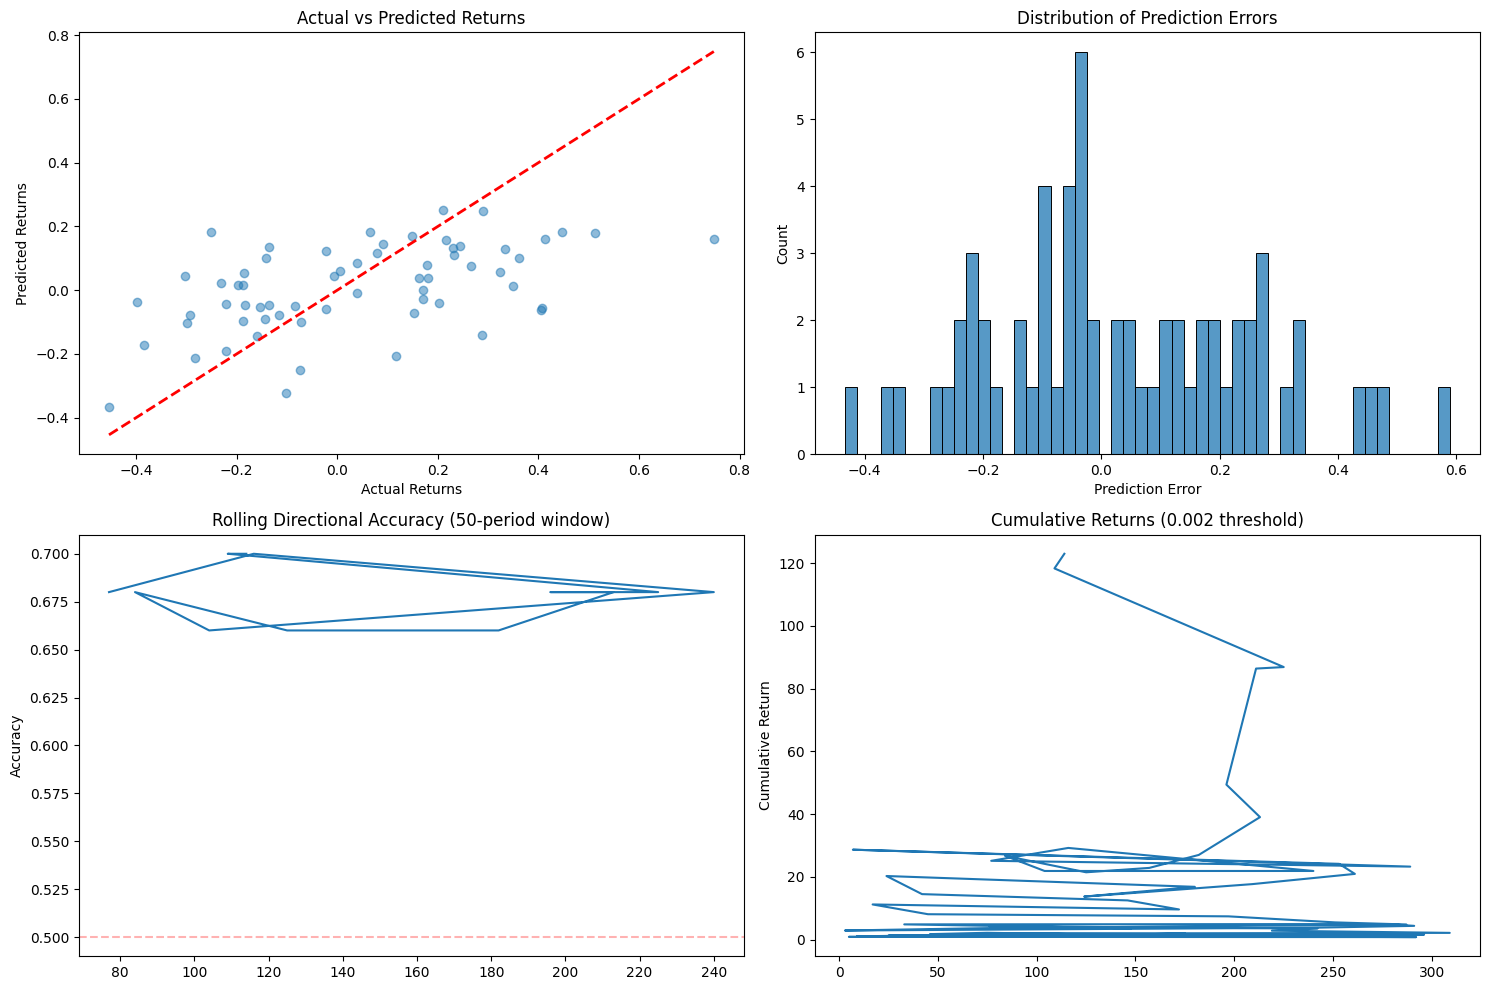

In [42]:
# Plotting
plt.figure(figsize=(15, 10))

# Plot 1: Actual vs Predicted
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title('Actual vs Predicted Returns')

# Plot 2: Prediction Error Distribution
plt.subplot(2, 2, 2)
errors = y_test - y_pred
sns.histplot(errors, bins=50)
plt.title('Distribution of Prediction Errors')
plt.xlabel('Prediction Error')

# Plot 3: Rolling Directional Accuracy
plt.subplot(2, 2, 3)
rolling_acc = (np.sign(y_pred) == np.sign(y_test))
rolling_accuracy = rolling_acc.rolling(50).mean()
plt.plot(rolling_accuracy)
plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.3)
plt.title('Rolling Directional Accuracy (50-period window)')
plt.ylabel('Accuracy')

# Plot 4: Cumulative Returns
plt.subplot(2, 2, 4)
returns = calculate_returns(y_pred, y_test, threshold=0.002)  # Using 0.002 threshold
cum_returns = (1 + returns).cumprod()
plt.plot(cum_returns)
plt.title('Cumulative Returns (0.002 threshold)')
plt.ylabel('Cumulative Return')

plt.tight_layout()
plt.show()

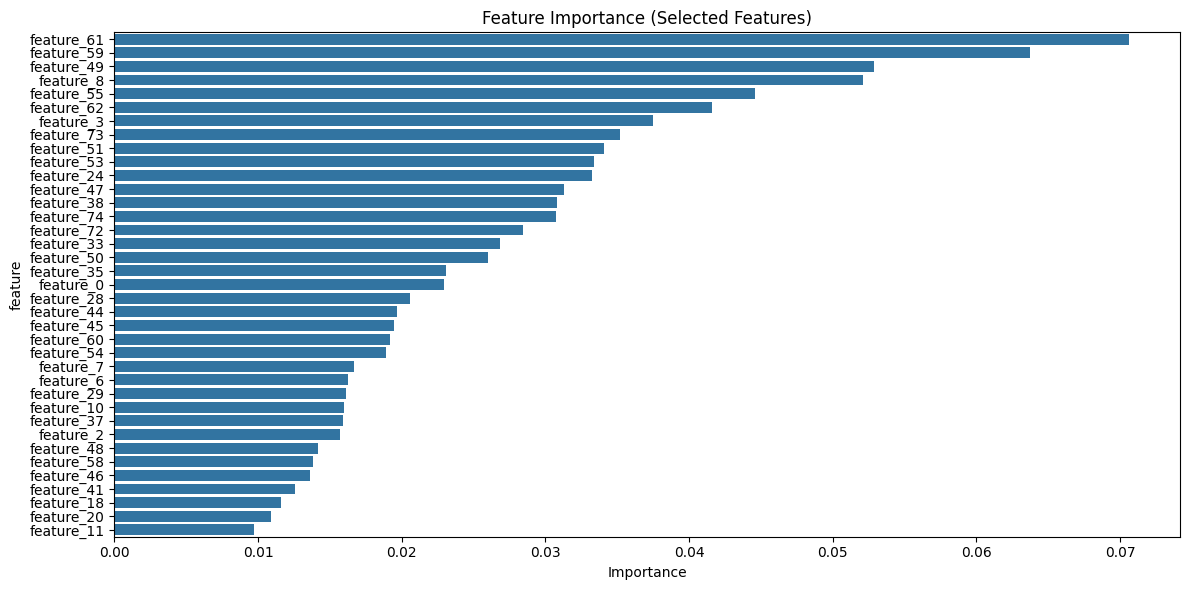

In [43]:
# Feature importance for selected features
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': final_model.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance (Selected Features)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

## Categorization problem

Target Return Statistics:
count    5746.000000
mean        0.005599
std         0.220234
min        -1.401949
25%        -0.106014
50%         0.015357
75%         0.129103
max         1.353311
Name: target, dtype: float64

Percentiles:
1th percentile: -0.582636
5th percentile: -0.361621
10th percentile: -0.259458
20th percentile: -0.143867
30th percentile: -0.076926
40th percentile: -0.025258
50th percentile: 0.015357
60th percentile: 0.054790
70th percentile: 0.102701
80th percentile: 0.158656
90th percentile: 0.252788
95th percentile: 0.346007
99th percentile: 0.524544


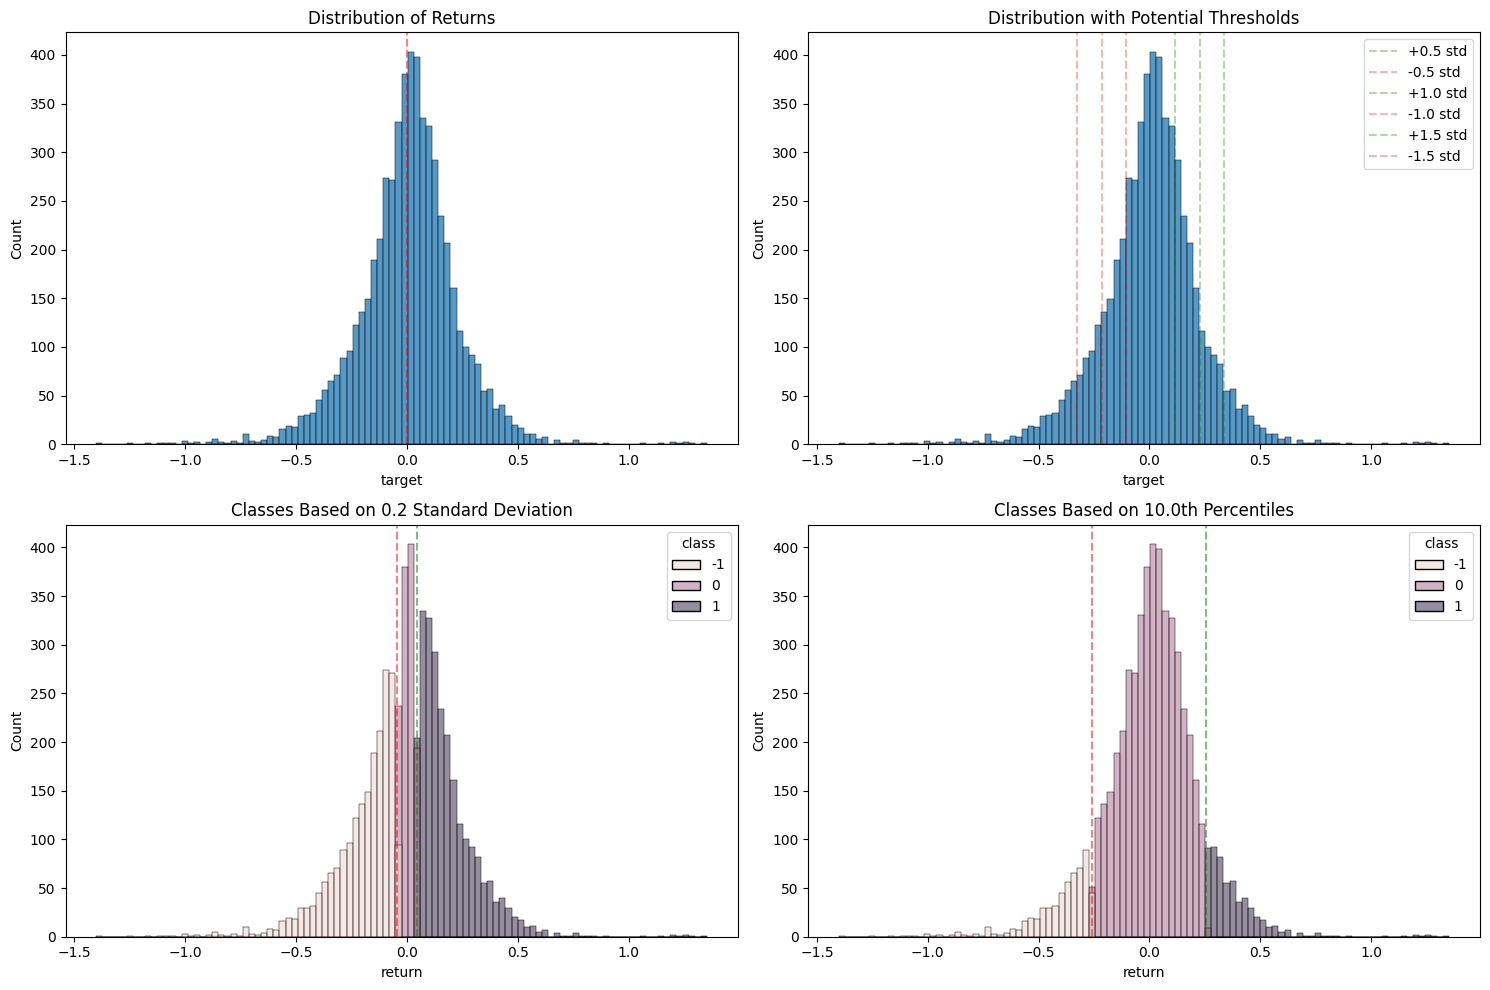


Class Distribution (STD-based):
 1    0.428124
-1    0.360599
 0    0.211277
Name: proportion, dtype: float64

Class Distribution (Percentile-based):
 0    0.799861
-1    0.100070
 1    0.100070
Name: proportion, dtype: float64

Mean Return by Class (STD-based):
class
-1   -0.208692
 0    0.001408
 1    0.188160
Name: return, dtype: float64

Mean Return by Class (Percentile-based):
class
-1   -0.411293
 0    0.010291
 1    0.384993
Name: return, dtype: float64


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the data
df = pd.read_csv('model_data.csv')

# Basic statistics of the target variable
print("Target Return Statistics:")
print(df['target'].describe())

# Calculate different percentiles
percentiles = [1, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 99]
print("\nPercentiles:")
for p in percentiles:
    print(f"{p}th percentile: {df['target'].quantile(p/100):.6f}")

# Plot distribution
plt.figure(figsize=(15, 10))

# Plot 1: Overall distribution
plt.subplot(2, 2, 1)
sns.histplot(df['target'], bins=100)
plt.title('Distribution of Returns')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)

# Plot 2: Distribution with potential thresholds
plt.subplot(2, 2, 2)
sns.histplot(df['target'], bins=100)
plt.title('Distribution with Potential Thresholds')

# Add lines for different standard deviations
std = df['target'].std()
mean = df['target'].mean()
for i in [0.5, 1.0, 1.5]:
    plt.axvline(x=mean + i*std, color='g', linestyle='--', alpha=0.3, label=f'+{i} std')
    plt.axvline(x=mean - i*std, color='r', linestyle='--', alpha=0.3, label=f'-{i} std')
plt.legend()

# Let's try different threshold approaches
# Approach 1: Standard deviation based
std_multiplier = 0.2
std_threshold = std_multiplier * std
labels_std = np.where(df['target'] > std_threshold, 1,
                     np.where(df['target'] < -std_threshold, -1, 0))

# Approach 2: Percentile based
percentile_threshold = 0.1  # top/bottom 20%
top_threshold = df['target'].quantile(1 - percentile_threshold)
bottom_threshold = df['target'].quantile(percentile_threshold)
labels_percentile = np.where(df['target'] > top_threshold, 1,
                           np.where(df['target'] < bottom_threshold, -1, 0))

# Plot 3: Distribution of STD-based classes
plt.subplot(2, 2, 3)
sns.histplot(data=pd.DataFrame({'return': df['target'], 'class': labels_std}), 
            x='return', hue='class', bins=100)
plt.title(f'Classes Based on {std_multiplier} Standard Deviation')
plt.axvline(x=std_threshold, color='g', linestyle='--', alpha=0.5)
plt.axvline(x=-std_threshold, color='r', linestyle='--', alpha=0.5)

# Plot 4: Distribution of Percentile-based classes
plt.subplot(2, 2, 4)
sns.histplot(data=pd.DataFrame({'return': df['target'], 'class': labels_percentile}), 
            x='return', hue='class', bins=100)
plt.title(f'Classes Based on {percentile_threshold*100}th Percentiles')
plt.axvline(x=top_threshold, color='g', linestyle='--', alpha=0.5)
plt.axvline(x=bottom_threshold, color='r', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

# Print class distributions
print("\nClass Distribution (STD-based):")
print(pd.Series(labels_std).value_counts(normalize=True))

print("\nClass Distribution (Percentile-based):")
print(pd.Series(labels_percentile).value_counts(normalize=True))

# Calculate mean return for each class
print("\nMean Return by Class (STD-based):")
std_df = pd.DataFrame({'return': df['target'], 'class': labels_std})
print(std_df.groupby('class')['return'].mean())

print("\nMean Return by Class (Percentile-based):")
perc_df = pd.DataFrame({'return': df['target'], 'class': labels_percentile})
print(perc_df.groupby('class')['return'].mean())

### Categorization of returns based on 0.5 standard deviation of train data

Create labels

In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectFromModel
import optuna

# Read and prepare the data
df = pd.read_csv('model_data.csv')
df = df.drop('ts_event', axis=1)

# Separate features and target
X = df.drop('target', axis=1)
y = df['target']

# Split the data first so we only use train data statistics for thresholds
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Calculate threshold based on training data only
train_std = y_train.std()
threshold = 0.2 * train_std

# Transform targets into classes (update this function) instead of -1,0,1 do 0,1,2
def create_labels(y, threshold):
    return np.where(y > threshold, 2,
                   np.where(y < -threshold, 0, 1))

y_train_classes = create_labels(y_train, threshold)
y_test_classes = create_labels(y_test, threshold)

# Print class distribution
print("Training Class Distribution:")
print(pd.Series(y_train_classes).value_counts(normalize=True))
print("\nTest Class Distribution:")
print(pd.Series(y_test_classes).value_counts(normalize=True))



Training Class Distribution:
2    0.445783
0    0.385542
1    0.168675
Name: proportion, dtype: float64

Test Class Distribution:
2    0.476190
0    0.428571
1    0.095238
Name: proportion, dtype: float64


In [68]:
# Scale features
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Feature selection
def select_features(X_train_scaled, X_test_scaled, X, threshold=0.01):
    model = xgb.XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        num_class=3
    )
    model.fit(X_train_scaled, y_train_classes)
    
    selector = SelectFromModel(model, prefit=True, threshold=threshold)
    X_train_selected = selector.transform(X_train_scaled)
    X_test_selected = selector.transform(X_test_scaled)
    
    selected_features = X.columns[selector.get_support()].tolist()
    print(f"Selected {len(selected_features)} features")
    
    return X_train_selected, X_test_selected, selected_features

# Optuna objective function
def objective(trial):
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.1, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 7),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True)
    }
    
    model = xgb.XGBClassifier(
        objective='multi:softprob',
        random_state=42,
        num_class=3,
        **params
    )
    
    model.fit(
        X_train_selected,
        y_train_classes,
        eval_set=[(X_test_selected, y_test_classes)],
        early_stopping_rounds=20,
        verbose=False
    )
    
    preds = model.predict(X_test_selected)
    return accuracy_score(y_test_classes, preds)

# Perform feature selection
X_train_selected, X_test_selected, selected_features = select_features(X_train_scaled, X_test_scaled, X)

# Optimize hyperparameters
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

best_params = study.best_params
print("\nBest hyperparameters:", best_params)

# Train final model with best parameters
final_model = xgb.XGBClassifier(
    objective='multi:softprob',
    random_state=42,
    num_class=3,
    **best_params
)

# Train with early stopping
final_model.fit(
    X_train_selected,
    y_train_classes,
    eval_set=[(X_test_selected, y_test_classes)],
    early_stopping_rounds=20,
    verbose=False
)

# Make predictions
y_pred = final_model.predict(X_test_selected)
y_pred_proba = final_model.predict_proba(X_test_selected)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred))



[I 2024-11-04 18:05:57,282] A new study created in memory with name: no-name-2c6daeda-9e92-46a1-b618-64e79c6e0689


Selected 48 features


/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
[I 2024-11-04 18:06:00,421] Trial 0 finished with value: 0.6190476190476191 and parameters: {'learning_rate': 0.006454743183426614, 'max_depth': 8, 'min_child_weight': 2, 'subsample': 0.8576765105659356, 'colsample_bytree': 0.7776000535653083, 'gamma': 0.29136769056879175, 'n_estimators': 290, 'reg_alpha': 0.0016997085105950845, 'reg_lambda': 0.017353125063523364}. Best is trial 0 with value: 0.6190476190476191.
/Users/davidbrazda/Documents/Development/python/mlroom/.venv/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_


Best hyperparameters: {'learning_rate': 0.004868986265506842, 'max_depth': 10, 'min_child_weight': 7, 'subsample': 0.96910688673596, 'colsample_bytree': 0.9053391423525449, 'gamma': 0.09486695144580468, 'n_estimators': 160, 'reg_alpha': 2.3987247918147813e-08, 'reg_lambda': 0.6782714031188876}

Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.63      0.68        27
           1       0.33      0.17      0.22         6
           2       0.68      0.83      0.75        30

    accuracy                           0.68        63
   macro avg       0.58      0.54      0.55        63
weighted avg       0.67      0.68      0.67        63



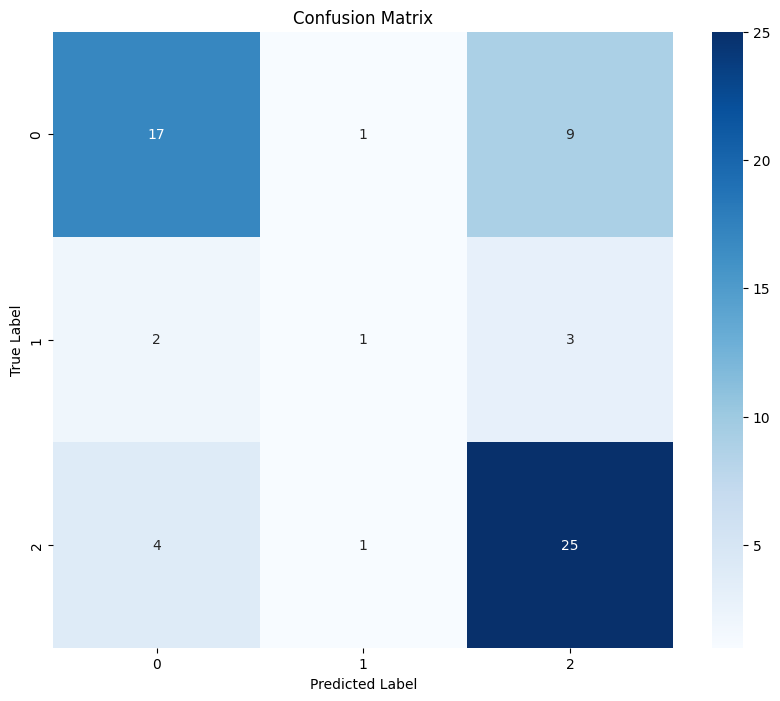

In [70]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test_classes, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()




Performance at different confidence thresholds:
   confidence_threshold    sharpe  accuracy  coverage
0                   0.4  9.209426  0.706897  0.968254
1                   0.5  8.392427  0.686275  0.857143
2                   0.6  7.797934  0.707317  0.650794
3                   0.7  7.904583  0.840000  0.396825
4                   0.8  3.751478  0.875000  0.126984


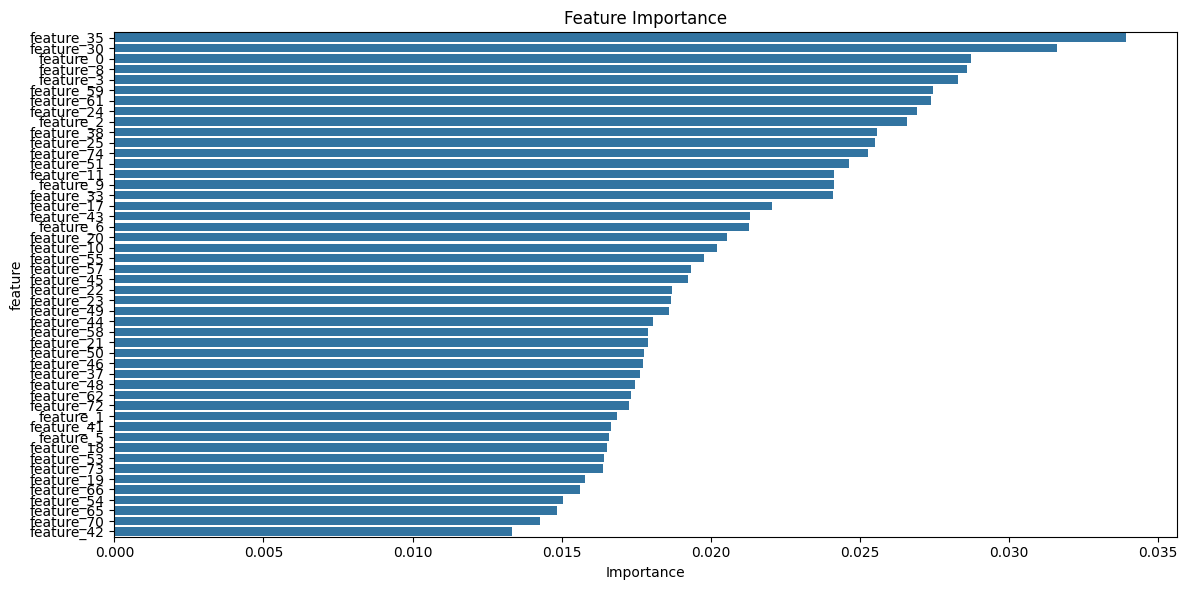

In [61]:
# Calculate returns based on predictions
def calculate_returns(predictions, actual_returns, confidence_threshold=0.0):
    pred_probs = final_model.predict_proba(X_test_selected)
    max_probs = np.max(pred_probs, axis=1)
    
    # Only take positions when confidence exceeds threshold
    positions = np.zeros_like(predictions, dtype=float)
    confident_mask = max_probs > confidence_threshold
    
    # Convert predictions 0->-1, 2->1 for returns calculation
    adj_predictions = np.where(predictions == 2, 1, np.where(predictions == 0, -1, 0))
    positions[confident_mask] = adj_predictions[confident_mask]
    
    returns = positions * actual_returns
    return returns, np.mean(confident_mask)

# Test different confidence thresholds
confidence_thresholds = [0.4, 0.5, 0.6, 0.7, 0.8]
results = []

for conf_threshold in confidence_thresholds:
    returns, coverage = calculate_returns(y_pred, y_test.values, conf_threshold)
    
    # Calculate metrics
    sharpe = np.sqrt(252) * returns.mean() / returns.std()
    accuracy = accuracy_score(y_test_classes[returns != 0], 
                            y_pred[returns != 0])
    
    results.append({
        'confidence_threshold': conf_threshold,
        'sharpe': sharpe,
        'accuracy': accuracy,
        'coverage': coverage
    })

results_df = pd.DataFrame(results)
print("\nPerformance at different confidence thresholds:")
print(results_df)

# Plot feature importance
importance_df = pd.DataFrame({
    'feature': selected_features,
    'importance': final_model.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x='importance', y='feature', data=importance_df)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()



In [1]:
# Plot cumulative returns
plt.figure(figsize=(12, 6))
for th in [0.2,0.3,0.4,0.6,0.8]:
    returns, _ = calculate_returns(y_pred, y_test.values, 0.6)  # Using 0.6 confidence threshold
    cumulative_returns = (1 + returns).cumprod()
    plt.plot(cumulative_returns)
plt.title('Cumulative Returns (0.6 confidence threshold)')
plt.xlabel('Trade Number')
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.show()



NameError: name 'plt' is not defined

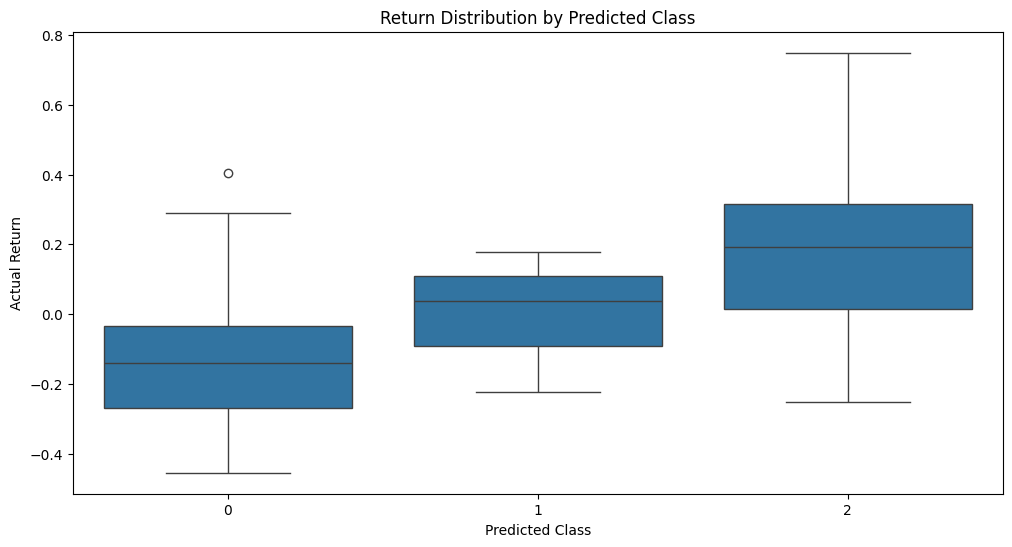

In [63]:
# Plot return distribution by predicted class
plt.figure(figsize=(12, 6))
sns.boxplot(x=y_pred, y=y_test.values)
plt.title('Return Distribution by Predicted Class')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Return')
plt.show()

In [64]:
# Save just the XGBoost model
final_model.save_model('xgb_model.json')  # or .bin format

# Load just the XGBoost model
# loaded_xgb = xgb.XGBClassifier()
# loaded_xgb.load_model('xgb_model.json')